In [1]:
import json
import torch_geometric
import collections
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import networkx as nx
import scipy.sparse as sp
from sklearn import preprocessing
from IPython.display import Image
import torch
from torch.nn import Linear
from sklearn.model_selection import train_test_split
import warnings
import torch.nn.functional 
from torch_geometric.nn import GCNConv
import chardet
from sklearn.manifold import TSNE
import torch.nn.functional as F
import scipy
%matplotlib inline

## Preparing Data

In [2]:
edges = pd.read_csv("C:\db\musae_facebook_edges.csv")
target = pd.read_csv("C:\db\musae_facebook_target.csv")
target = target.drop("facebook_id", axis="columns")
target = target.drop("page_name", axis="columns")
number_of_classes = len(target['page_type'].unique())
with open("C:\db\musae_facebook_features.json") as json_data:
    features = json.load(json_data)

## Creating feauture matrix

In [3]:
new_keys = []
max_feature = np.max([v for v_list in features.values() for v in v_list])
for i in list(features.keys()):
    new_keys.append(int(i))
np_edges_source = edges['id_1'].to_numpy()
np_edges_destination = edges['id_2'].to_numpy()
adjacency_matrix = np.zeros((target.shape[0], target.shape[0]))
feature_matrix = np.zeros(shape = (len(list(features.keys())) ,max_feature + 1))
i = 0
for key in new_keys:
    for i in features[f'{key}']:
        feature_matrix[key, i] = 1 
        

In [4]:
node_features = pd.DataFrame(feature_matrix)
number_of_features = feature_matrix.shape[1]
display(node_features.head())
print(f"Vector space dimension is {number_of_features}")

,0,1,2,3,4,5,6,7,8,9,...,4704,4705,4706,4707,4708,4709,4710,4711,4712,4713
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Vector space dimension is 4714


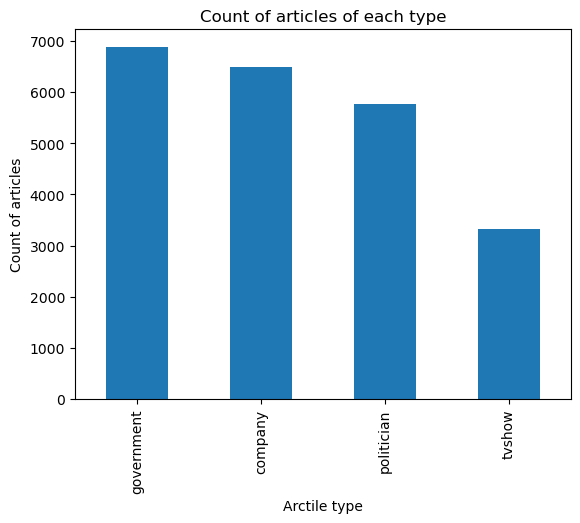

In [5]:
page_type_count = target['page_type'].value_counts()
page_type_count.plot(kind='bar')
plt.title('Count of articles of each type')
plt.xlabel('Arctile type')
plt.ylabel('Count of articles')
plt.show()

### In order to use each type of article in machine learning alghoritms we need to encode them into some numbers.

In [6]:
class_to_num = {'tvshow' : 0, 'government' : 1, 'company' : 2, 'politician' : 3}
target['page_type'].replace(class_to_num, inplace=True)
target

,id,page_type
0,0,0
1,1,1
2,2,2
3,3,1
4,4,3
...,...,...
22465,22465,3
22466,22466,2
22467,22467,1
22468,22468,2


## Splitting data in train/test set

In [7]:
num_nodes = node_features.shape[0]
train_pages, test_pages = train_test_split(target['id'].to_numpy(), train_size=200)
val_pages, test_pages = train_test_split(test_pages, train_size=200)

## Here we a going to make train and test mask for using only nodes from train and test set while training and testing our model

In [17]:
train_mask =  torch.zeros(num_nodes, dtype=torch.bool)
train_mask = torch.tensor([i in train_pages for i in range(len(train_mask))])
test_mask =  torch.zeros(num_nodes, dtype=torch.bool)
test_mask = torch.tensor([i in test_pages for i in range(len(test_mask))])
y = torch.tensor(target['page_type'].to_numpy())

## In order to use PyLib pytorch_geometric we need to make variable edge_index which is adjacency list of input graph. We will use edge_index when train the model.

In [18]:
lst = np.array([[np_edges_source],[np_edges_destination]])
edge_index = torch.from_numpy(lst)
edge_index = edge_index.squeeze(dim=1)
edge_index

tensor([[    0,     1,     1,  ..., 22348,  5563, 22425],
        [18427, 21708, 22208,  ..., 22348,  5563, 22425]])

## GCN model for node classification using pytorch_geometric

In [19]:
class GCN(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, output_dim)
        
    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

## Training our model

In [29]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GCN(number_of_features, 32, number_of_classes).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-4)
criterion = torch.nn.CrossEntropyLoss()
def train_model():
    model.train()
    optimizer.zero_grad() 
    out = model(torch.tensor(feature_matrix).to(dtype=torch.float32), edge_index.to(torch.int32))
    loss = criterion(out[train_mask], y[train_mask])  
    loss.backward() 
    optimizer.step()
    return loss
losses = []
for epoch in range(0, 301):
    loss = train_model()
    losses.append(loss)
    if epoch % 100 == 0:
        print(f'Epoch: {epoch}, Loss: {loss}')

    

Epoch: 0, Loss: 1.396329402923584
Epoch: 100, Loss: 0.003965826705098152
Epoch: 200, Loss: 0.007099758367985487
Epoch: 300, Loss: 0.004318695981055498


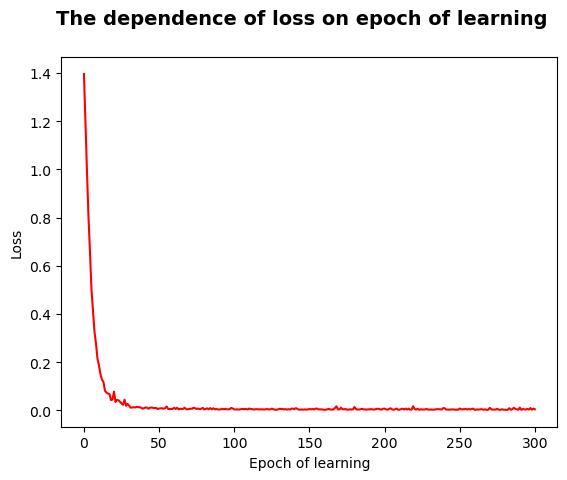

In [31]:
lost_list = [losses[i].item() for i in range(len(losses))]
fig, ax1 = plt.subplots()
ax1.plot(list(range(0,301)),lost_list, 'r')
ax1.set_xlabel('Epoch of learning')
ax1.set_ylabel('Loss')
plt.suptitle('The dependence of loss on epoch of learning', fontsize=14, fontweight='bold')
plt.show()

## Testing our model

In [23]:
def test_model():
    model.eval()
    out = model(torch.tensor(feature_matrix).to(dtype=torch.float32), edge_index.to(torch.int32))
    pred = out.argmax(dim=1)  
    test_correct = pred[test_mask] == y[test_mask]  
    test_acc = int(test_correct.sum()) / int(test_mask.sum())  
    return test_acc

In [24]:
test_accuracy = test_model()
print(f'Test Accuracy is {test_accuracy:.2f}')

Test Accuracy is 0.77


## Here we are going to vizualize node embeddings. For that we need to reduce the dimension of vector space.

In [25]:

def plt_to_arr(fig):
    rgb_str = fig.canvas.tostring_rgb()
    (w,h) = fig.canvas.get_width_height()
    rgba_arr = np.fromstring(rgb_str, dtype=np.uint8, sep='').reshape((w,h,-1))
    return rgba_arr
def visualize(h, color, epoch):
    fig = plt.figure(figsize=(7,7))
    fig.suptitle(f'Epoch: {epoch}')
    z = TSNE(n_components=2).fit_transform(out.detach().numpy())
    plt.xticks([])
    plt.yticks([])
    plt.scatter(z[:, 0], 
                z[:, 1], 
                s=20, 
                c=color.detach().numpy(), 
                cmap="Set1")
    fig.canvas.draw()
    return plt_to_arr(fig)

for layer in model.children():
    if hasattr(layer, 'reset_parameters'):
         layer.reset_parameters()

TSNE Visualization finished.


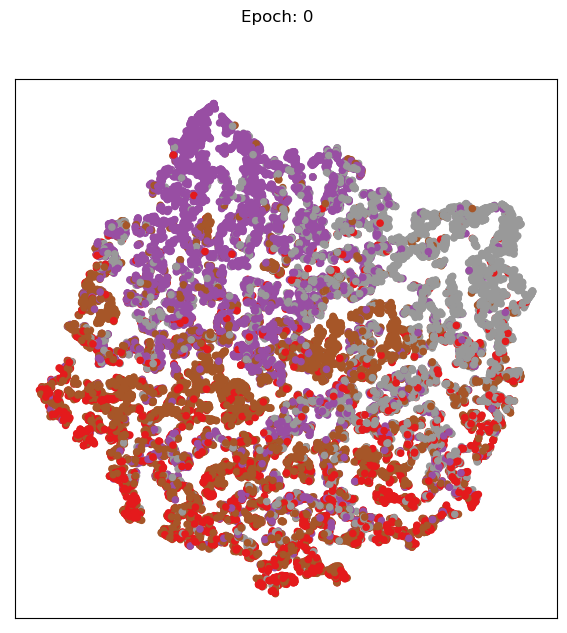

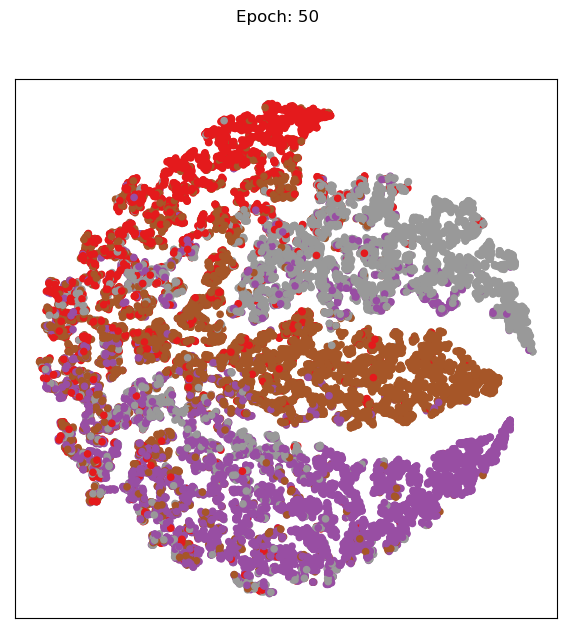

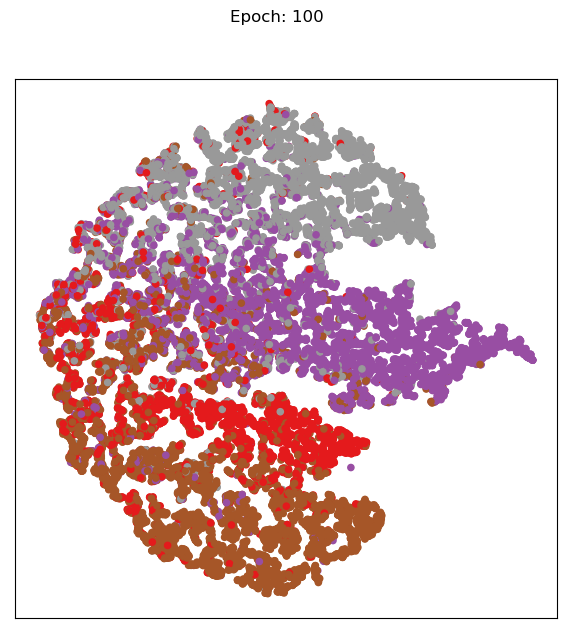

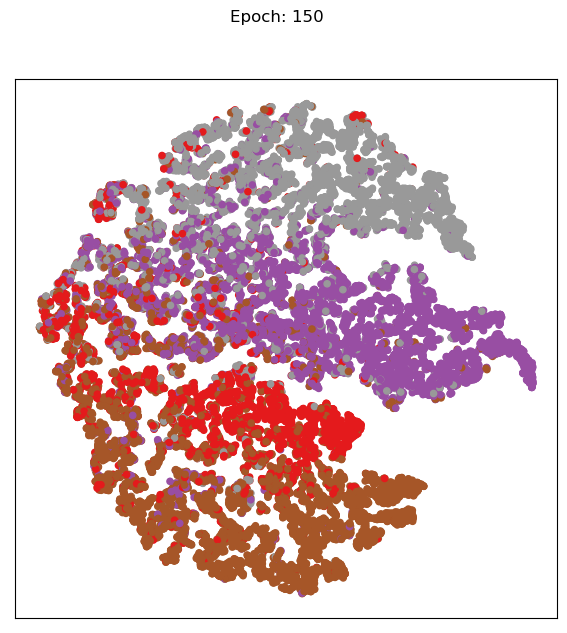

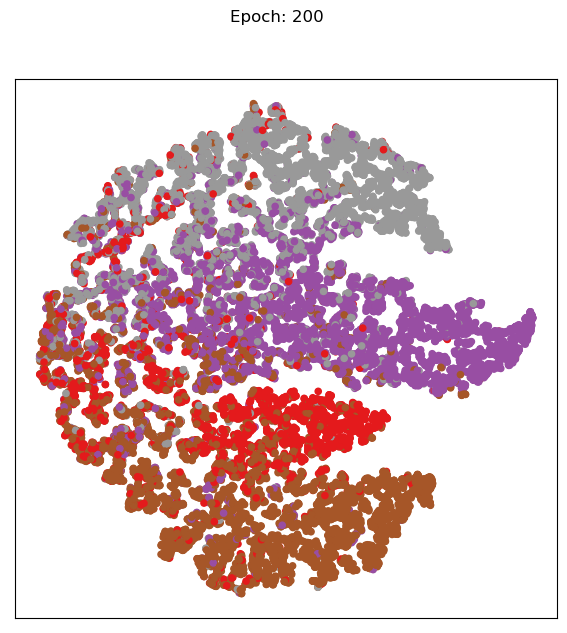

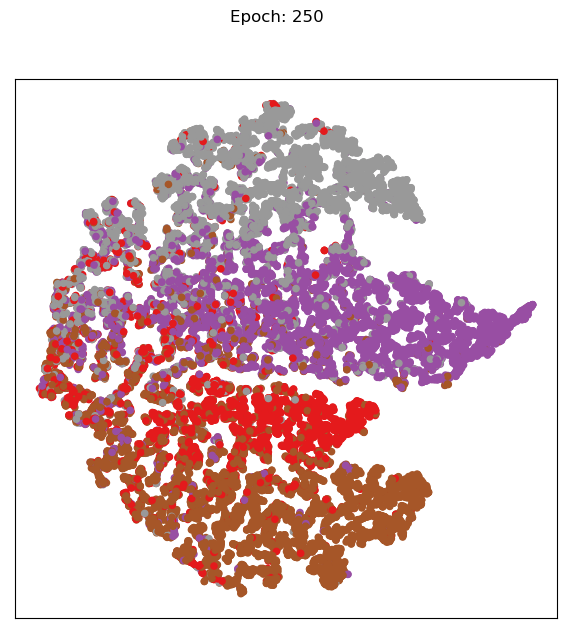

In [26]:
import warnings
warnings.filterwarnings('ignore')
images = []
for epoch in range(0, 300):
    loss = train()
    if epoch % 50 == 0:
        out = model(torch.tensor(feature_matrix).to(dtype=torch.float32), edge_index.to(torch.int32))
        images.append(visualize(out, color=y, epoch=epoch))
print("TSNE Visualization finished.")

In [27]:
from moviepy.editor import ImageSequenceClip
fps = 1
filename = "C:/Users/ermil/embeddings.gif"
clip = ImageSequenceClip(images, fps=fps)
clip.write_gif(filename, fps=fps)

MoviePy - Building file C:/Users/ermil/embeddings.gif with imageio.


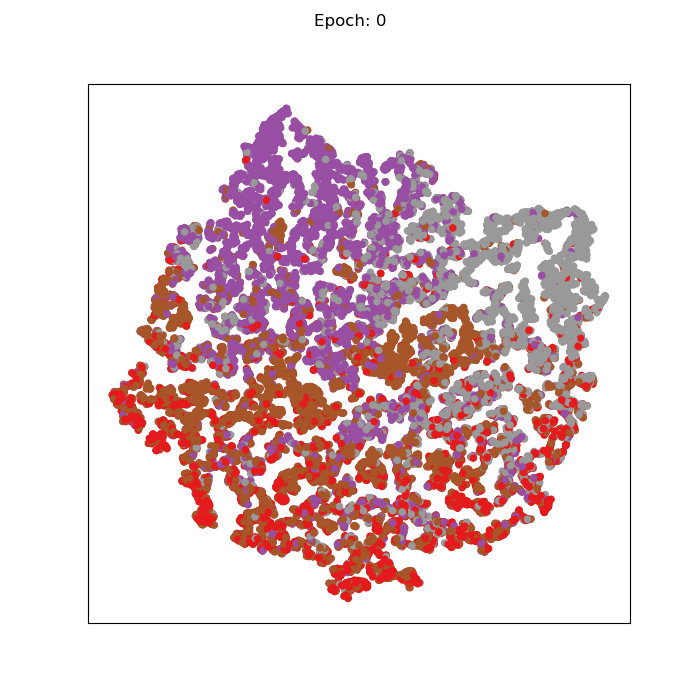

In [28]:
from IPython.display import Image
with open('C:/Users/ermil/embeddings.gif','rb') as f:
    display(Image(data=f.read(), format='png'))